In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Multi-Armed Bandits Class

In [2]:
arm_rewards = {
        'RL Course by RC': 0.08,
        'Optimization course at Amazon': 0.3,
        'Trading Course by TikTok Guru': 0.05,
}

In [4]:
class Environment:
    def __init__(self, arm_rewards):
        self.arm_rewards = np.array(list(arm_rewards.values()))

    @property
    def n_arms(self):
        return self.arm_rewards.shape[0]

    @property
    def best_arm(self):
        return np.argmax(self.arm_rewards)

    def step(self, arm):
        if np.random.random() < self.arm_rewards[arm]:
            return 1
        return 0

    def regret(self, pulled_arms): # TODO
        n_steps = len(pulled_arms)
        best_total_reward = self.arm_rewards[self.best_arm] * n_steps
        total_reward = self.arm_rewards[pulled_arms].sum()
        return best_total_reward - total_reward

In [5]:
env = Environment(arm_rewards)
for _ in range(10):
    # pull a random arm
    arm = random.randint(0, env.n_arms - 1)
    observed_reward = env.step(arm)
    print(f'Pulled arm {arm} and got reward {observed_reward}')

Pulled arm 1 and got reward 0
Pulled arm 2 and got reward 0
Pulled arm 0 and got reward 0
Pulled arm 0 and got reward 0
Pulled arm 1 and got reward 0
Pulled arm 0 and got reward 0
Pulled arm 2 and got reward 0
Pulled arm 0 and got reward 0
Pulled arm 2 and got reward 0
Pulled arm 1 and got reward 0


# Greedy Algorithm

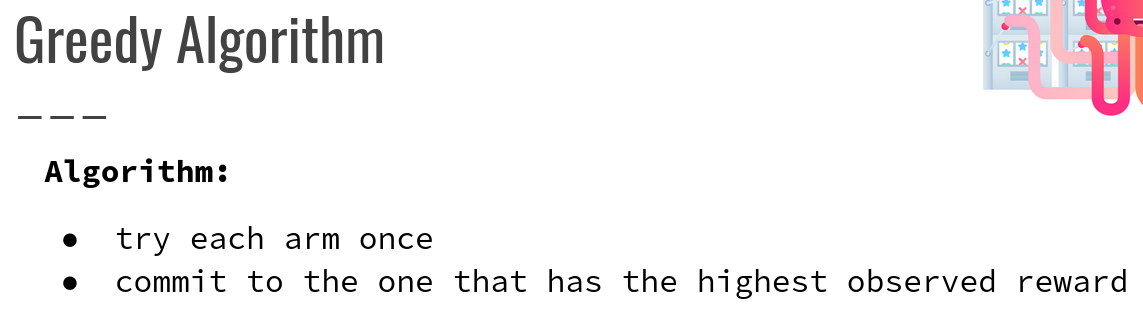

In [6]:
def mab_greedy(env, total_steps):
    # Initialize array of observed rewards
    observed_rewards = np.full(total_steps, fill_value=-1.0)
    observed_regret = 0
    pulled_arms = []

    # Explore
    for k in range(env.n_arms):
        arm = k # TODO
        observed_rewards[k] = env.step(arm)
        pulled_arms.append(arm)
        observed_regret += env.arm_rewards[env.best_arm] - observed_rewards[k] # TODO

    best_observed_arm = np.argmax(observed_rewards[0:env.n_arms]) # TODO

    # Exploit
    for i in range(env.n_arms, total_steps):
        arm = best_observed_arm # TODO
        observed_rewards[i] = env.step(arm)
        pulled_arms.append(arm)
        observed_regret += env.arm_rewards[env.best_arm] - observed_rewards[i] # TODO
    return observed_rewards, observed_regret, np.array(pulled_arms), best_observed_arm

In [9]:
env = Environment(arm_rewards)

print(f'arm_rewards: {env.arm_rewards}')

observed_arm_rewards, observed_regret, pulled_arms, best_observed_arm = mab_greedy(env, total_steps=1000)
regret = env.regret(pulled_arms)

print(f'observed_rewards: {observed_arm_rewards[0:3]}')
print(f'best_observed_arm: {best_observed_arm}')
print(f'observed_regret: {observed_regret}')
print(f'regret: {regret}')

arm_rewards: [0.08 0.3  0.05]
observed_rewards: [0. 1. 0.]
best_observed_arm: 1
observed_regret: -3.9999999999998
regret: 0.47000000000008413


# Explore & Commit Algorithm

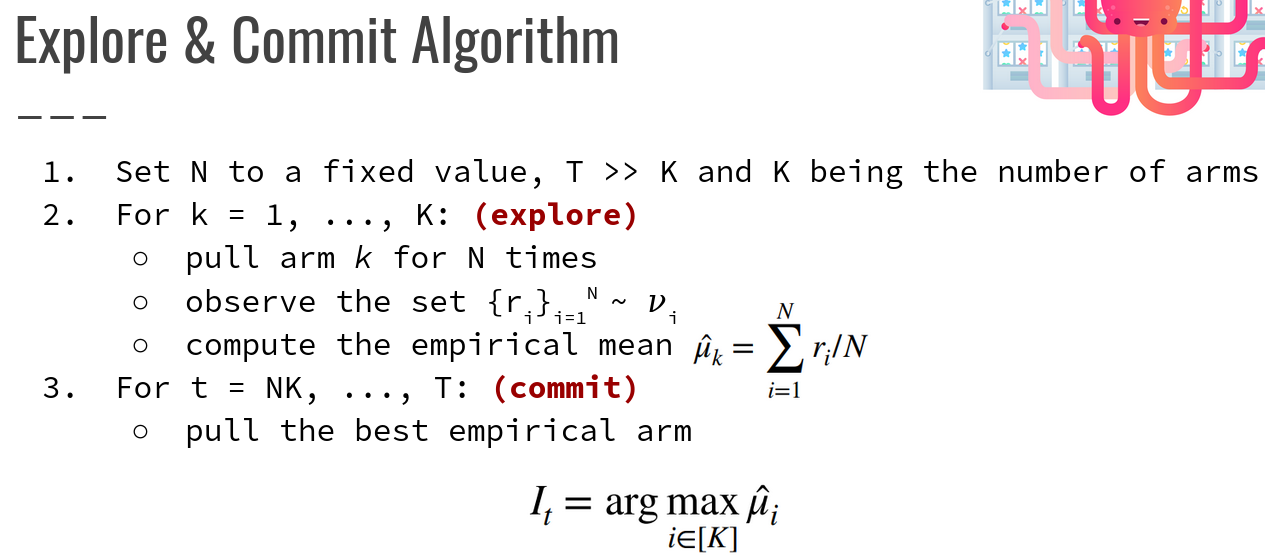

In [10]:
def mab_explore_and_commit(env, trials_per_arm, total_steps):
    observed_rewards = np.full(total_steps, fill_value=-1.0)
    # Initialize array of observed reward means
    observed_reward_means = np.zeros(env.n_arms)
    observed_regret = 0
    pulled_arms = []

    # Explore
    for k in range(env.n_arms):
        observed_arm_rewards = np.zeros(trials_per_arm)
        for i in range(trials_per_arm):
            arm = k # TODO
            observed_arm_rewards[i] = env.step(arm)
            pulled_arms.append(arm)
            observed_rewards[k*trials_per_arm + i] = observed_arm_rewards[i]
            observed_regret += env.arm_rewards[env.best_arm] - observed_arm_rewards[i] # TODO
        observed_reward_means[k] = observed_arm_rewards.sum() / trials_per_arm # TODO

    best_observed_arm = np.argmax(observed_reward_means) # TODO

    # Commit
    for i in range(env.n_arms * trials_per_arm, total_steps):
        arm = best_observed_arm # TODO
        observed_rewards[i] = env.step(arm)
        pulled_arms.append(arm)
        observed_regret += env.arm_rewards[env.best_arm] - observed_rewards[i] # TODO
    return observed_rewards, observed_regret, np.array(pulled_arms), best_observed_arm, observed_reward_means

In [17]:
env = Environment(arm_rewards)

print(f'arm_rewards: {env.arm_rewards}')

_, observed_regret, pulled_arms, best_observed_arm, observed_reward_means = mab_explore_and_commit(env, trials_per_arm=10, total_steps=1000)
regret = env.regret(pulled_arms)

print(f'observed_reward_means: {observed_reward_means}')
print(f'best_observed_arm: {best_observed_arm}')
print(f'observed_regret: {observed_regret}')
print(f'regret: {regret}')

arm_rewards: [0.08 0.3  0.05]
observed_reward_means: [0.1 0.4 0.1]
best_observed_arm: 1
observed_regret: 4.000000000000279
regret: 4.7000000000000455


# UCB Algorithm

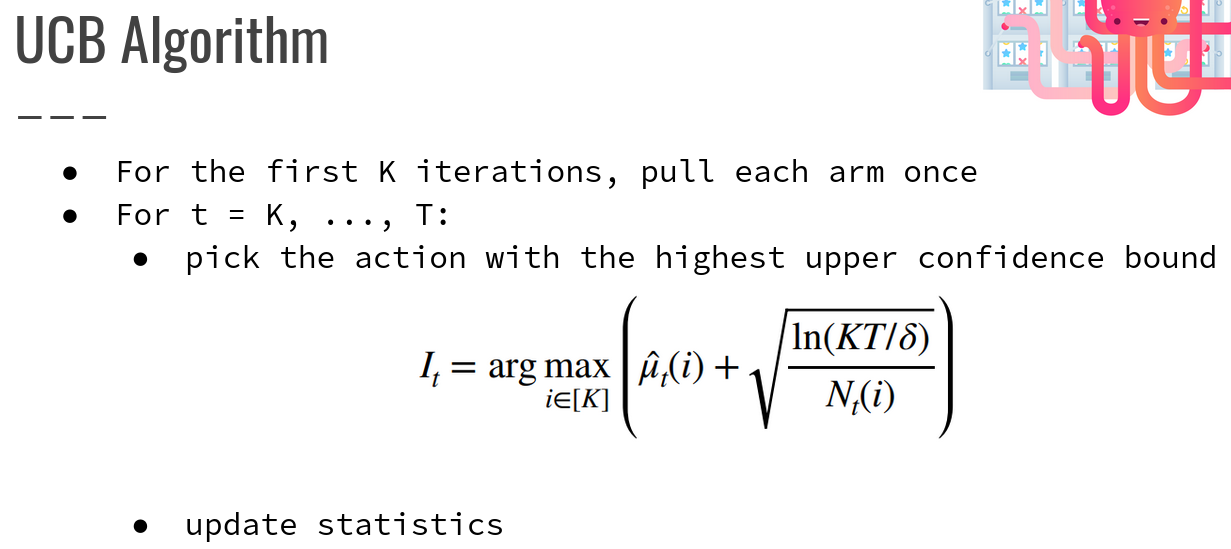

In [19]:
def mab_ucb(env, delta, total_steps):
    # Initialize array of observed rewards
    observed_rewards = np.full(total_steps, fill_value=-1.0)
    observed_regret = 0
    pulled_arms = []

    # Pull each arm once
    for k in range(env.n_arms):
        arm = k # TODO
        observed_rewards[k] = env.step(arm)
        pulled_arms.append(arm)
        observed_regret += env.arm_rewards[env.best_arm] - observed_rewards[k] # TODO

    # Initialize statistics
    observed_reward_means = observed_rewards[0:env.n_arms] # TODO
    arm_pull_counts = np.ones(env.n_arms) # TODO

    # Pull arms using UCB
    for i in range(env.n_arms, total_steps):
        ucbs = observed_reward_means + np.sqrt(np.log(total_steps*env.n_arms/delta) / arm_pull_counts) # TODO
        arm = np.argmax(ucbs) # TODO

        observed_rewards[i] = env.step(arm)
        pulled_arms.append(arm)
        observed_regret += env.arm_rewards[env.best_arm] - observed_rewards[i] # TODO

        # Update statistics
        observed_reward_means[arm] = (observed_reward_means[arm]*arm_pull_counts[arm] + observed_rewards[i]) / (arm_pull_counts[arm] + 1) # TODO
        arm_pull_counts[arm] += 1 # TODO

    return observed_rewards, observed_regret, np.array(pulled_arms)

In [25]:
env = Environment(arm_rewards)

print(f'arm_rewards: {env.arm_rewards}')

_, observed_regret, pulled_arms = mab_ucb(env, delta=0.2, total_steps=1000)
regret = env.regret(pulled_arms)

print(f'observed_regret: {observed_regret}')
print(f'regret: {regret}')

arm_rewards: [0.08 0.3  0.05]
observed_regret: 43.99999999999837
regret: 42.51000000000005


# Comparison

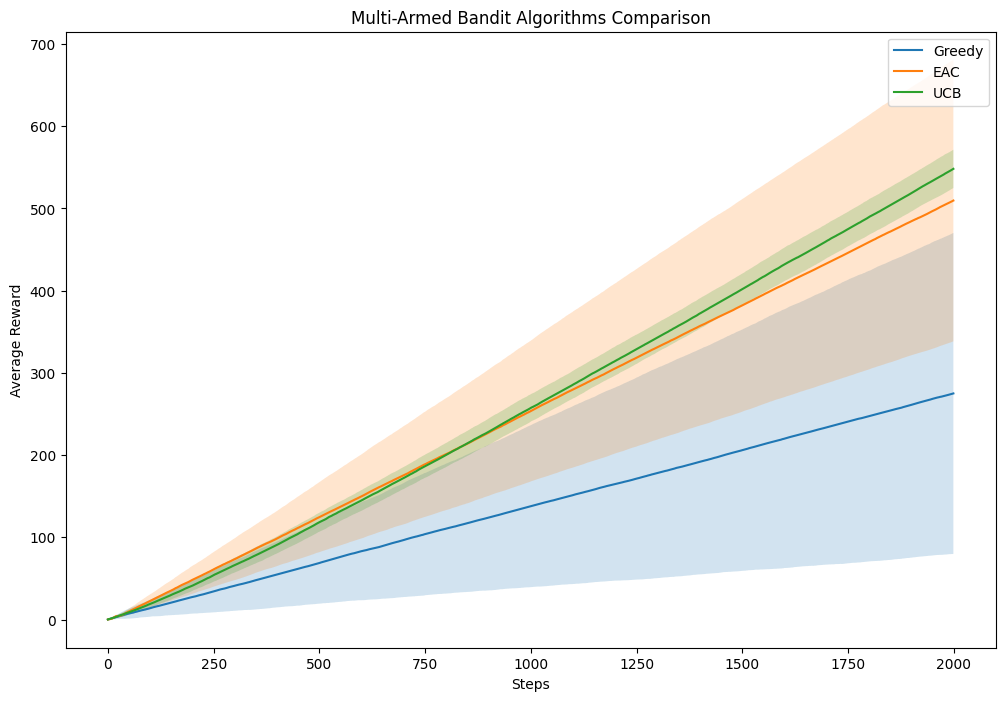

In [29]:
n_runs = 100
steps_per_run = 2000
results_greedy = np.zeros((n_runs, steps_per_run))
results_eac = np.zeros((n_runs, steps_per_run))
results_ucb = np.zeros((n_runs, steps_per_run))

# repeat each algorithm n_runs times and store the observed_rewards
for i in range(n_runs):
    results_greedy[i], _, _, _ = mab_greedy(env, total_steps=steps_per_run)
    results_eac[i], _, _, _, _ = mab_explore_and_commit(env, trials_per_arm=10, total_steps=steps_per_run)
    results_ucb[i], _, _ = mab_ucb(env, delta=0.2, total_steps=steps_per_run)

# turn the observed rewards into cumulative observed rewards
results_greedy = results_greedy.cumsum(axis=1)
results_eac = results_eac.cumsum(axis=1)
results_ucb = results_ucb.cumsum(axis=1)

# plot the average cumulative observed rewards for each algorithm as a curve with shaded standard deviation
plt.figure(figsize=(12, 8))
plt.plot(results_greedy.mean(axis=0), label='Greedy')
plt.fill_between(range(steps_per_run), results_greedy.mean(axis=0) - results_greedy.std(axis=0), results_greedy.mean(axis=0) + results_greedy.std(axis=0), alpha=0.2)
plt.plot(results_eac.mean(axis=0), label='EAC')
plt.fill_between(range(steps_per_run), results_eac.mean(axis=0) - results_eac.std(axis=0), results_eac.mean(axis=0) + results_eac.std(axis=0), alpha=0.2)
plt.plot(results_ucb.mean(axis=0), label='UCB')
plt.fill_between(range(steps_per_run), results_ucb.mean(axis=0) - results_ucb.std(axis=0), results_ucb.mean(axis=0) + results_ucb.std(axis=0), alpha=0.2)
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Multi-Armed Bandit Algorithms Comparison')
plt.show()